<a href="https://colab.research.google.com/github/keerthanar09/CrowdAnalyzer/blob/main/CrowdAnalyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install ultralytics opencv-python scikit-learn numpy

##General Pipeline

`Takes Input` (CCTV footage) -> `Divide it to zones` (16 zones) -> `Detect People using the YOLOv8 Model` -> `Extract features per zone `(such as people count, density, clustering, motion) -> `Train a classifier` (its a placeholder and will be replaced with a predictive model) -> `REturns JSON`

##CrowdAnalyser Class

*Attributes of this class include:*
- Face detection model
- Grid specifications using `gridsize`. ((4,4) suggests a 4x4 grid, creating 16 zones)
- Classifier/Predictive Model.



In [ ]:
import cv2
import numpy as np
import json
from ultralytics import YOLO
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

class CrowdAnalyser:
  def __init__(self, grid_size = (4,4)):
    self.model = YOLO('yolov8n.pt')
    self.grid_size = grid_size
    self.classifier = None

  def divide_frame(self, frame):
    h, w, _ = frame.shape
    gh, gw = self.grid_size
    stepx = w//gw
    stepy = h//gh
    zones = []
    for i in range(gh):
      for j in range(gw):
        x1 = j*stepx
        x2 = (j+1)*stepx
        y1 = i*stepy
        y2 = (i+1)*stepy
        zones.append(((x1, y1, x2, y2), f"{chr(65+i)}{j+1}"))
        # print(zones)
    return zones

  def extract_features(self, frame):
        results = self.model(frame, verbose=False)
        people = [box.xyxy[0].cpu().numpy() for box in results[0].boxes if int(box.cls[0]) == 0]

        zones = self.divide_frame(frame)
        features = {}

        for (x1, y1, x2, y2), zone_name in zones:
            zone_people = [p for p in people if x1 <= (p[0]+p[2])/2 <= x2 and y1 <= (p[1]+p[3])/2 <= y2]
            n_people = len(zone_people)

            density = n_people / ((x2-x1)*(y2-y1))
            centroids = [((p[0]+p[2])/2, (p[1]+p[3])/2) for p in zone_people]
            cluster_count = self.detect_clusters(centroids)

            features[zone_name] = [n_people, density, cluster_count]

        return features

  def detect_clusters(self, points, distance_thresh=50):
      if not points:
          return 0
      clusters, visited = [], set()
      for i, p1 in enumerate(points):
          if i in visited:
              continue
          cluster = [p1]
          for j, p2 in enumerate(points):
              if i != j and np.linalg.norm(np.array(p1)-np.array(p2)) < distance_thresh:
                  cluster.append(p2)
                  visited.add(j)
          clusters.append(cluster)
      return len(clusters)

  def train_classifier(self, X, y):
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.classifier.fit(X, y)

  def classify_zones(self, features):
        if self.classifier is None:
            raise ValueError("Classifier not trained yet!")

        json_output = {"zones": {}}
        for zone, feats in features.items():
            pred = self.classifier.predict([feats])[0]
            json_output["zones"][zone] = {
                "people": feats[0],
                "density": feats[1],
                "clusters": feats[2],
                "state": pred
            }
        return json.dumps(json_output, indent=2)


if __name__ == "__main__":
    analyzer = CrowdAnalyser(grid_size=(4, 4))

    X = [
        [5, 0.0001, 1],   # low density, calm
        [40, 0.002, 3],   # high density, overcrowded
        [20, 0.001, 4],   # clusters
        [30, 0.0015, 2],  # chaotic
    ]
    y = ["calm", "overcrowded", "clustered", "chaotic"]

    analyzer.train_classifier(X, y)
    cap = cv2.VideoCapture("/content/crowd_video.mp4")
    ret, frame = cap.read()
    if ret:
        features = analyzer.extract_features(frame)
        output = analyzer.classify_zones(features)
        print(output)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
{
  "zones": {
    "A1": {
      "people": 3,
      "density": 0.00020833333333333335,
      "clusters": 1,
      "state": "calm"
    },
    "A2": {
      "people": 6,
      "density": 0.0004166666666666667,
      "clusters": 3,
      "state": "calm"
    },
    "A3": {
      "people": 6,
      "density": 0.0004166666666666667,
      "clusters": 3,
      "state": "calm"
    },
    "A4": {
      "people": 8,
      "density": 0.0005555555555555556,
      "clusters": 2,
      "state": "clustered"
    },
    "B1": {
      "people": 1,
      "density": 6.944444444444444e-05,
      "clusters": 1,
      "state": "calm"
    },
    "B2": {
      "people": 3,
      "density": 0.0002083333333

[((0, 0, 160, 90), 'A1')]
[((0, 0, 160, 90), 'A1'), ((160, 0, 320, 90), 'A2')]
[((0, 0, 160, 90), 'A1'), ((160, 0, 320, 90), 'A2'), ((320, 0, 480, 90), 'A3')]
[((0, 0, 160, 90), 'A1'), ((160, 0, 320, 90), 'A2'), ((320, 0, 480, 90), 'A3'), ((480, 0, 640, 90), 'A4')]
[((0, 0, 160, 90), 'A1'), ((160, 0, 320, 90), 'A2'), ((320, 0, 480, 90), 'A3'), ((480, 0, 640, 90), 'A4'), ((0, 90, 160, 180), 'B1')]
[((0, 0, 160, 90), 'A1'), ((160, 0, 320, 90), 'A2'), ((320, 0, 480, 90), 'A3'), ((480, 0, 640, 90), 'A4'), ((0, 90, 160, 180), 'B1'), ((160, 90, 320, 180), 'B2')]
[((0, 0, 160, 90), 'A1'), ((160, 0, 320, 90), 'A2'), ((320, 0, 480, 90), 'A3'), ((480, 0, 640, 90), 'A4'), ((0, 90, 160, 180), 'B1'), ((160, 90, 320, 180), 'B2'), ((320, 90, 480, 180), 'B3')]
[((0, 0, 160, 90), 'A1'), ((160, 0, 320, 90), 'A2'), ((320, 0, 480, 90), 'A3'), ((480, 0, 640, 90), 'A4'), ((0, 90, 160, 180), 'B1'), ((160, 90, 320, 180), 'B2'), ((320, 90, 480, 180), 'B3'), ((480, 90, 640, 180), 'B4')]
[((0, 0, 160, 90), 'A1')

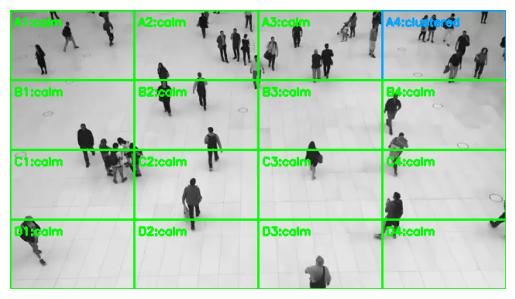

In [ ]:
#For development only :)
def visualize(frame, features, predictions, grid_size=(4,4)):
    h, w, _ = frame.shape
    gh, gw = grid_size
    stepx, stepy = w // gw, h // gh

    for i in range(gh):
        for j in range(gw):
            x1, y1 = j * stepx, i * stepy
            x2, y2 = (j+1) * stepx, (i+1) * stepy
            zone = f"{chr(65+i)}{j+1}"

            if zone in predictions["zones"]:
                state = predictions["zones"][zone]["state"]
            else:
                state = "unknown"
            if state == "calm":
                color = (0, 255, 0)
            elif state == "overcrowded":
                color = (0, 0, 255)
            elif state == "clustered":
                color = (255, 165, 0)
            elif state == "chaotic":
                color = (255, 0, 0)
            else:
                color = (200, 200, 200)

            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f"{zone}:{state}", (x1+5, y1+20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return frame

features = analyzer.extract_features(frame)
predictions = json.loads(analyzer.classify_zones(features))
vis_frame = visualize(frame, features, predictions, grid_size=(4,4))
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



##Changes Needed:
- Predictive model instead of classifier model
- Real datasets to train data


In [ ]:
!tar -tzf /content/UCSD_Anomaly_Dataset.tar.gz | head -n 50


UCSD_Anomaly_Dataset.v1p2/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/139.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/051.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/166.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/136.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/178.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/043.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/167.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/004.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/171.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/157.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/119.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/141.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/113.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/162.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/175.tif
UCSD_An